In [1]:
from IPython.core.debugger import set_trace

# Imports

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import time
import pickle
from datetime import datetime
from tqdm.auto import tqdm

from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.metrics import mean_squared_error as MSE

import fftoptionlib as fft
import QuantLib as ql

In [29]:
%load_ext autoreload
%autoreload 2
from models import SABR, Heston, Variance_Gamma

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MSFT data

In [4]:
msft_calls = pd.read_pickle("data/msft_calls.pickle")
msft_puts = pd.read_pickle("data/msft_puts.pickle")
expirations = pd.read_pickle("data/expirations.pickle")

msft_stock_price = 294.3900146484375
evaluation_date = '2022-03-16'
maturities = np.array([
    (datetime.strptime(expiration, '%Y-%m-%d') - 
    (datetime.strptime(evaluation_date, '%Y-%m-%d') if evaluation_date else datetime.today())).days / 256 
    for expiration in expirations
])

ql.Settings.instance().evaluationDate = ql.Date(16, 3, 2022)

# Support functions

In [5]:
def black_scholes(S, K, T, r, sigma, option='call'):
    """
    Black-Scholes closed-form formula for European call and put options.
    
    Parameters:
        S (float): underlying asset price
        K (float): option strike price
        T (float): time to maturity in years
        r (float): risk-free interest rate
        sigma (float): volatility of the underlying asset
        option (str): 'call' for call option, 'put' for put option (default is 'call')
    
    Returns:
        float: option price according to the Black-Scholes formula
    """
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Option type must be 'call' or 'put'")

In [6]:
def plot_surface(X,Y,Z, title):
    X, Y = np.meshgrid(X, Y)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15,6))
    ax.set_title(title)

    surf = ax.plot_surface(X, Y, Z, 
                        cmap=cm.coolwarm,
                        linewidth=0.1,
                        edgecolor='white')

    fig.colorbar(surf, shrink=0.3, aspect=10)
    ax.set_zlabel('Implied volatility')
    ax.set_xlabel('Strike, $')
    ax.set_ylabel('Maturity, years')
    plt.show()

In [7]:
def plot_opt_prices(
    strikes, 
    opt_prices, 
    expirations,
    stock_price=msft_stock_price, 
    title=''
):
    if opt_prices.shape[0] == len(expirations):
        opt_prices = opt_prices.T
        
    plt.figure(figsize=(8,5))
    plt.title(title)
    for i, e in enumerate(expirations):
        plt.plot(strikes, opt_prices[:,i], marker='.', label=e)
    plt.axvline(stock_price, c='red', linestyle='--', label='Stock price')
    plt.legend(title='Expiration date', framealpha=0.5)
    plt.xlabel('Stike, $')
    plt.ylabel('Option price, $')
    plt.show()

# Data preparation for build surfaces

Intersect available strikes between different expirations to get a complete grid for the implied volatility surface

## Call options

In [8]:
df_lens = np.array([len(df) for df in msft_calls])
indxs = np.where((df_lens >= 40) & (df_lens <= 90))[0]

msft_calls = [msft_calls[i] for i in indxs]
expirations = [expirations[i] for i in indxs]
maturities = maturities[indxs]

strikes = msft_calls[0].strike
for row in msft_calls:
  strikes = np.intersect1d(strikes, row.strike)

opt_prices = np.array([(df.bid + df.ask)[df.strike.isin(strikes)] / 2 for df in msft_calls])
opt_prices[np.isnan(opt_prices)] = 3.5e-2

vols = np.array([df.impliedVolatility.loc[df.strike.isin(strikes)] for df in msft_calls])

In [9]:
# df_lens = np.array([len(df) for df in msft_puts])
# indxs = np.where((df_lens >= 40) & (df_lens <= 90))[0]

# msft_puts = [msft_puts[i] for i in indxs]
# expirations_puts = [expirations[i] for i in indxs]
# maturities_puts = maturities[indxs]

# strikes_put = msft_puts[0].strike
# for row in msft_puts:
#   strikes_put = np.intersect1d(strikes_put, row.strike)

# opt_prices_put = np.array([(df.bid + df.ask)[df.strike.isin(strikes_put)] / 2 for df in msft_puts])
# opt_prices_put[np.isnan(opt_prices_put)] = 3.5e-2

# vols_put = np.array([df.impliedVolatility.loc[df.strike.isin(strikes_put)] for df in msft_puts])

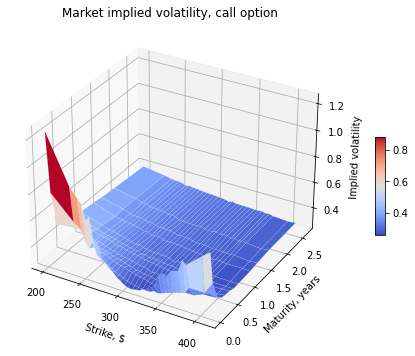

In [9]:
plot_surface(strikes, maturities, vols, title='Market implied volatility, call option');

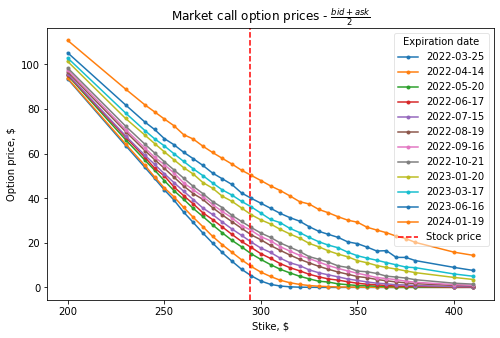

In [10]:
plot_opt_prices(strikes, opt_prices, np.array(expirations), title=r'Market call option prices - $\frac{bid + ask}{2}$')

# Models

## SABR
### Call

In [11]:
%%time
sabr = SABR(msft_stock_price)

sabr_times = []
for i, t, in enumerate(tqdm(maturities)):
    start = time.time()
    sabr.fit(strikes, vols[i,:], t)
    end = time.time()
    sabr_times.append(end-start)

100%|██████████| 12/12 [00:00<00:00, 65.70it/s]

sabr init
CPU times: user 179 ms, sys: 27.2 ms, total: 206 ms
Wall time: 195 ms


In [12]:
print(f'SABR call calibration time {np.sum(sabr_times):0.5f} sec.')

SABR call calibration time 0.18156 sec.


In [13]:
strikes_net = np.arange(strikes.min(), strikes.max(), 5)
sabr_surface = sabr.iv_surface(strikes_net, maturities)

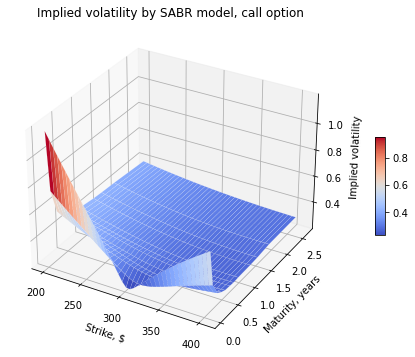

In [14]:
plot_surface(strikes_net, maturities, sabr_surface, 'Implied volatility by SABR model, call option')

### Train MSE

In [15]:
sabr_train_vols = sabr.iv_surface(strikes, maturities)

In [16]:
%%timeit
sabr_train_vols = sabr.iv_surface(strikes, maturities)

597 µs ± 63.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
MSE(vols, sabr_train_vols)

0.00019039910138429766

### All MSE

In [18]:
sabr.MSE_all(msft_calls, maturities)

0.023799102705323216

### Option prices

In [19]:
sabr_opt_prices = black_scholes(
    msft_stock_price, 
    strikes, 
    maturities[:,None], 
    0.05, 
    sabr_train_vols
)
MSE(opt_prices, sabr_opt_prices)

163.94688889641148

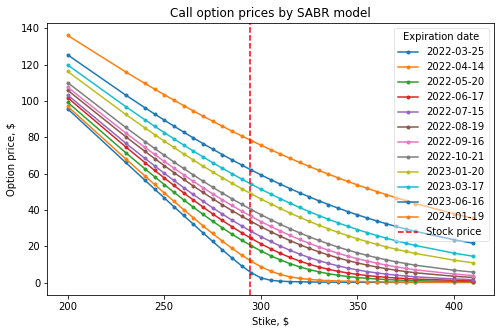

In [20]:
plot_opt_prices(strikes, sabr_opt_prices, expirations, title='Call option prices by SABR model')

## Heston

In [21]:
%%time
heston = Heston(msft_stock_price)
heston.fit(strikes, vols, expirations, method='L-BFGS-B')

CPU times: user 20.7 s, sys: 166 ms, total: 20.9 s
Wall time: 21.4 s


In [22]:
strikes_net = np.arange(strikes.min(), strikes.max(), 5)
heston_surface = heston.iv_surface(strikes_net, maturities)

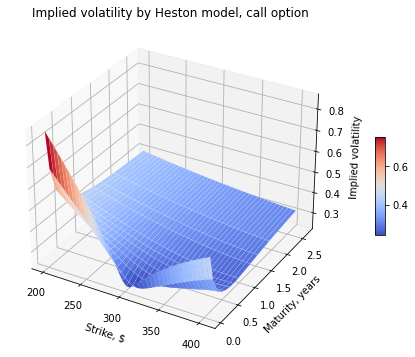

In [23]:
plot_surface(strikes_net, maturities, heston_surface, 'Implied volatility by Heston model, call option')

### Train MSE

In [24]:
%%time
heston_train_vols = heston.iv_surface(strikes, maturities)

CPU times: user 35.9 ms, sys: 367 µs, total: 36.3 ms
Wall time: 36.4 ms


In [25]:
MSE(vols, heston_train_vols)

0.001444723719149025

### All MSE

In [26]:
heston.MSE_all(msft_calls, maturities)

0.02492440573633768

### Option prices

In [27]:
heston_opt_prices = np.zeros((len(expirations), len(strikes)), dtype=float)

for i,t in enumerate(tqdm(expirations)):
    exercise = ql.EuropeanExercise(ql.Date(t, '%Y-%m-%d'))
    for j,K in enumerate(strikes):
        payoff = ql.PlainVanillaPayoff(ql.Option.Call, K)
        option = ql.EuropeanOption(payoff, exercise)
        option.setPricingEngine(heston.engine)
        heston_opt_prices[i,j] = option.NPV()

MSE(opt_prices, heston_opt_prices)

100%|██████████| 12/12 [00:00<00:00, 324.64it/s]


42.461732490667465

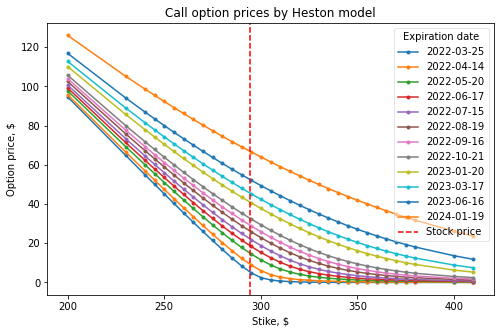

In [28]:
plot_opt_prices(strikes, heston_opt_prices, expirations, title='Call option prices by Heston model')

## Variance-Gamma

In [30]:
%%time
vg = Variance_Gamma(msft_stock_price, option_type='call')

vg_times = []
for i, expir in enumerate(tqdm(expirations)):
    start = time.time()
    vg.fit(expir, strikes, vols[i,:])
    end = time.time()
    vg_times.append(end-start)

100%|██████████| 12/12 [00:17<00:00,  1.50s/it]

CPU times: user 17.1 s, sys: 391 ms, total: 17.5 s
Wall time: 18 s


In [31]:
strikes_net = np.arange(strikes.min(), strikes.max(), 5)
vg_surface = vg.iv_surface(strikes_net, expirations)

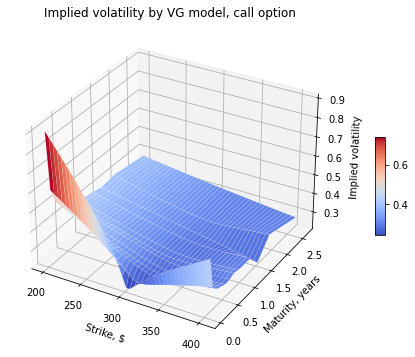

In [32]:
plot_surface(strikes_net, maturities, vg_surface, 'Implied volatility by VG model, call option')

### Train MSE

In [33]:
%%time
vg_train_vols = vg.iv_surface(strikes, expirations)

CPU times: user 129 ms, sys: 5.58 ms, total: 135 ms
Wall time: 135 ms


In [34]:
MSE(vols, vg_train_vols)

0.001272358967862138

### All MSE

In [35]:
vg.MSE_all(msft_calls, expirations)

0.026878652717685744

### Option prices


In [36]:
vg_opt_prices = np.zeros((len(expirations), len(strikes)), dtype=float)
for i, exp in enumerate(tqdm(expirations)):
    option_obj = vg.get_option_obj(exp)
    vg_opt_prices[i] = vg.get_vg_prices(*vg.params[i], option_obj, strikes)

MSE(opt_prices, vg_opt_prices)

100%|██████████| 12/12 [00:00<00:00, 93.34it/s]


34.816420442940064

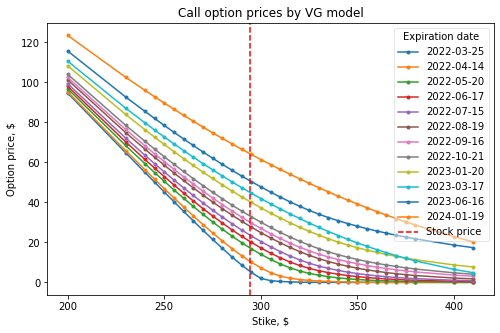

In [37]:
plot_opt_prices(strikes, vg_opt_prices, expirations, title='Call option prices by VG model')

# Near and far MSE

In [38]:
mask1 = maturities <= 1
mask2 = maturities > 1

for mod in ['sabr', 'heston', 'vg']:
    print(mod)
    print('Near', MSE(opt_prices[mask1], globals()[f'{mod}_opt_prices'][mask1]))
    print('Far', MSE(opt_prices[mask2], globals()[f'{mod}_opt_prices'][mask2]))

sabr
Near 48.87810406783499
Far 394.08445855356445
heston
Near 7.980790475209162
Far 111.42361652158405
vg
Near 9.017377492508707
Far 86.41450634380277


# Upload neural network results

In [39]:
with open('data/results/nn_a_call_surface.pkl', 'rb') as f:
    nn_a_call_surface = pickle.load(f)

with open('data/results/nn_b_call_surface.pkl', 'rb') as f:
    nn_b_call_surface = pickle.load(f)

In [ ]:
# with open('data/results/nn_a_put_surface.pkl', 'rb') as f:
#     nn_a_put_surface = pickle.load(f)

# with open('data/results/nn_b_put_surface.pkl', 'rb') as f:
#     nn_b_put_surface = pickle.load(f)

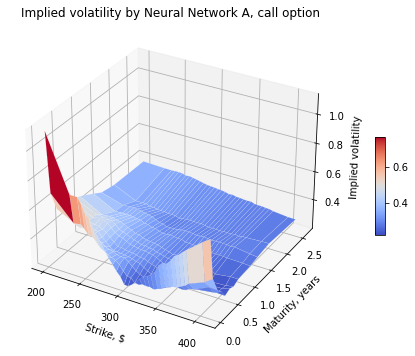

In [40]:
plot_surface(strikes, maturities, nn_a_call_surface, title='Implied volatility by Neural Network A, call option')

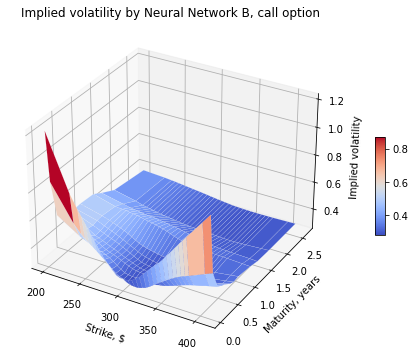

In [41]:
plot_surface(strikes, maturities, nn_b_call_surface, title='Implied volatility by Neural Network B, call option')

In [43]:
nn_a_call_opt_prices = black_scholes(msft_stock_price, strikes, maturities[:,None], 0.05, nn_a_call_surface, 'call')
nn_b_call_opt_prices = black_scholes(msft_stock_price, strikes, maturities[:,None], 0.05, nn_b_call_surface, 'call')

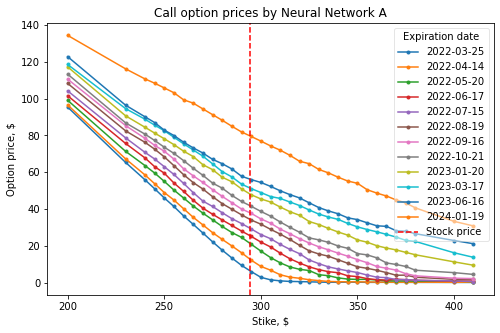

In [44]:
plot_opt_prices(strikes, nn_a_call_opt_prices, expirations, title='Call option prices by Neural Network A')

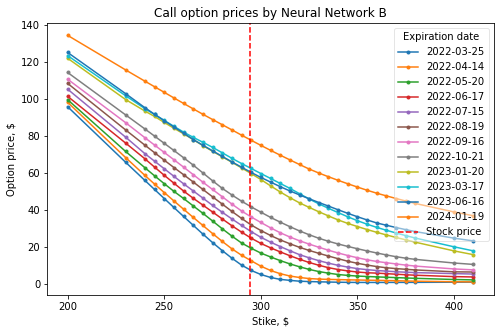

In [45]:
plot_opt_prices(strikes, nn_b_call_opt_prices, expirations, title='Call option prices by Neural Network B')

In [46]:
for mod in ['nn_a', 'nn_b']:
    print(mod)
    print('Near', MSE(opt_prices[mask1], globals()[f'{mod}_call_opt_prices'][mask1]))
    print('Far', MSE(opt_prices[mask2], globals()[f'{mod}_call_opt_prices'][mask2]))

nn_a
Near 58.83336839406518
Far 355.33878556247606
nn_b
Near 69.76775074699911
Far 513.3286670075673


# Comparison all models

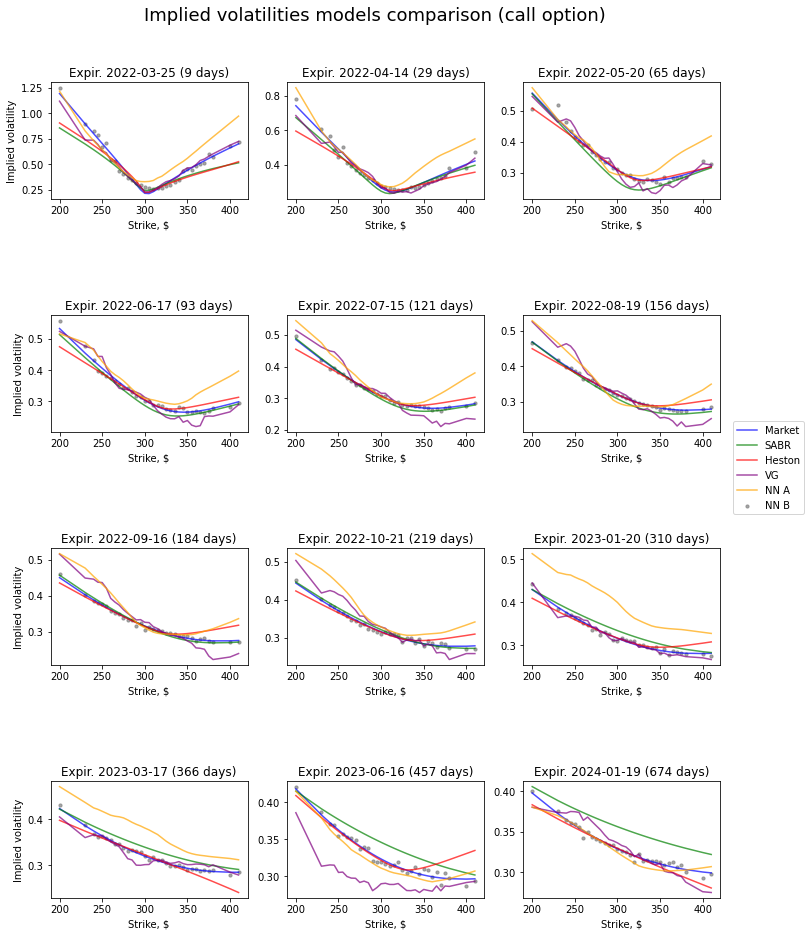

In [48]:
all_ivs = [
    vols,
    sabr_train_vols,
    heston_train_vols,
    vg_train_vols,
    nn_a_call_surface,
    nn_b_call_surface
]
labels = ['Market', 'SABR', 'Heston', 'VG', 'NN A', 'NN B']
colors = ['grey', 'b', 'g', 'r', 'purple', 'orange']

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 15))
plt.subplots_adjust(hspace=1)
fig.suptitle("Implied volatilities models comparison (call option)", fontsize=18, y=0.95)

for i, (exp, ax) in enumerate(zip(expirations, axs.ravel())):
    ax.set_title(f'Expir. {exp} ({int(maturities[i] * 256)} days)')
    ax.scatter(strikes, all_ivs[0][i], c=colors[0], label=labels[0], alpha=0.7, s=10)
    # ax.scatter(msft_calls[i].strike, msft_calls[i].impliedVolatility, c=colors[0], label=labels[0], alpha=0.7, s=10)
    for j in range(len(all_ivs)-1):
        ax.plot(strikes, all_ivs[j+1][i], c=colors[j+1], label=labels[j+1], alpha=0.7)
    # ax.get_legend().remove()
    ax.set_xlabel('Strike, $')
    if i % 3 == 0:
        ax.set_ylabel('Implied volatility')
    # ax.legend(loc='upper right')
    handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='right')
plt.show()

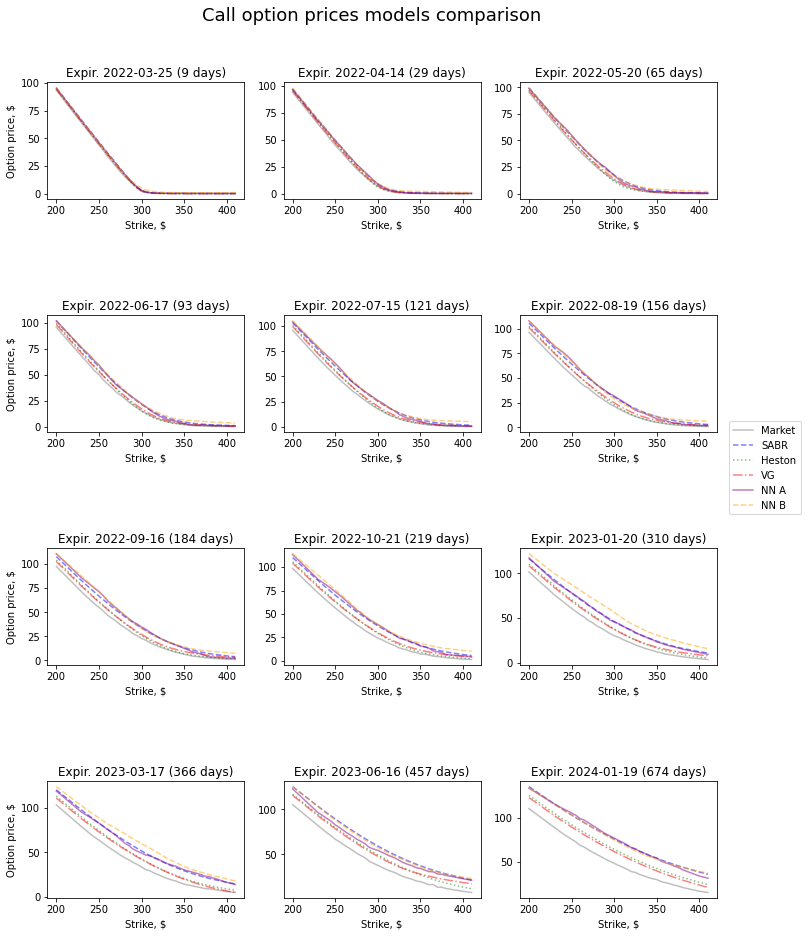

In [50]:
all_prices = [
    opt_prices,
    sabr_opt_prices,
    heston_opt_prices,
    vg_opt_prices,
    nn_a_call_opt_prices,
    nn_b_call_opt_prices,
]
labels = ['Market', 'SABR', 'Heston', 'VG', 'NN A', 'NN B']
colors = ['grey', 'b', 'g', 'r', 'purple', 'orange']
linestyles = ['solid', 'dashed', 'dotted', 'dashdot']

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(12, 15))
plt.subplots_adjust(hspace=1)
fig.suptitle("Call option prices models comparison", fontsize=18, y=0.95)

for i, (exp, ax) in enumerate(zip(expirations, axs.ravel())):
    ax.set_title(f'Expir. {exp} ({int(maturities[i] * 256)} days)')
    # ax.scatter(strikes, all_prices[0][i], c=colors[0], label=labels[0], alpha=0.5, s=10)
    for j in range(len(all_prices)):
        ax.plot(strikes, all_prices[j][i], c=colors[j], label=labels[j], alpha=0.5, linestyle=linestyles[j % 4])
    ax.set_xlabel('Strike, $')
    if i % 3 == 0:
        ax.set_ylabel('Option price, $')
    # ax.legend(loc='upper right')
    handles, labels = ax.get_legend_handles_labels()

fig.legend(handles, labels, loc='right')
plt.show()